In [1]:
# pip install gymnasium
import gymnasium as gym

import numpy as np
import random
import os
import collections

import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

mpl.rc('animation', html='jshtml')

# pip install array2gif
from array2gif import write_gif

### OpenAI Gym. Маятник на тележке - Cartpole

![cartpole](https://www.gymlibrary.dev/_images/cart_pole.gif)

<font size="3">
<p>Эта среда - одна из систем в <a href='https://www.gymlibrary.dev/environments/classic_control/index.html'>Classic Control environments</a>.</p>
<div class="table-wrapper colwidths-auto docutils container">
<table class="docutils align-default">
<thead>
<tr class="row-odd"><th class="head"><p></p></th>
<th class="head"><p></p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p>Пространство действий</p></td>
<td><p>Discrete(2)</p></td>
</tr>
<tr class="row-odd"><td><p>Размер вектора состояния</p></td>
<td><p>(4,)</p></td>
</tr>
<tr class="row-even"><td><p>Верхние границы</p></td>
<td><p>[4.8   inf 0.42  inf]</p></td>
</tr>
<tr class="row-odd"><td><p>Нижние границы</p></td>
<td><p>[-4.8   -inf -0.42  -inf]</p></td>
</tr>
<tr class="row-even"><td><p>Импорт</p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">gym.make(&quot;CartPole-v1&quot;)</span></code></p></td>
</tr>
</tbody>
</table>
</font>

In [2]:
env = gym.make('CartPole-v1', render_mode = 'rgb_array')

### Состояния

<table class="docutils align-default">
<thead>
<tr class="row-odd"><th class="head"><p>№</p></th>
<th class="head"><p>Переменная</p></th>
<th class="head"><p>Min</p></th>
<th class="head"><p>Max</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p>0</p></td>
<td><p>Положение тележки</p></td>
<td><p>-4.8</p></td>
<td><p>4.8</p></td>
</tr>
<tr class="row-odd"><td><p>1</p></td>
<td><p>Скорость тележки</p></td>
<td><p>-Inf</p></td>
<td><p>Inf</p></td>
</tr>
<tr class="row-even"><td><p>2</p></td>
<td><p>Угол маятника с вертикалью</p></td>
<td><p>~ -0.418 rad (-24°)</p></td>
<td><p>~ 0.418 rad (24°)</p></td>
</tr>
<tr class="row-odd"><td><p>3</p></td>
<td><p>Угловая скорость маятника</p></td>
<td><p>-Inf</p></td>
<td><p>Inf</p></td>
</tr>
</tbody>
</table>

In [3]:
env.observation_space.shape[0]

4

In [4]:
obs = env.reset()
obs

(array([ 0.04229295,  0.00602789, -0.02952096,  0.03477902], dtype=float32),
 {})

In [5]:
Obs = collections.namedtuple("CartPole_obs", "x v theta omega")
Obs(*obs[0])

CartPole_obs(x=0.04229295, v=0.006027888, theta=-0.029520962, omega=0.034779023)

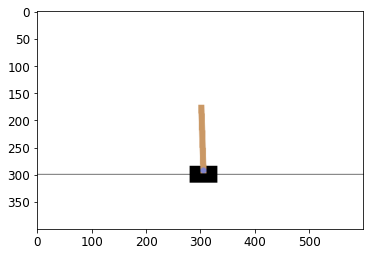

In [6]:
img = env.render()
plt.imshow(img)

### Начальные условия

Все переменные вектора состояний инициализируются случайными величинами равномерно распределёнными в интервале (-0.05, 0.05)


### Начало эпизода

In [7]:
obs = env.reset()
obs0 = Obs(*obs[0])
print(obs0)

CartPole_obs(x=-0.040047493, v=-0.0041600014, theta=0.045907978, omega=-0.012451039)


### Действия

<table class="docutils align-default">
<thead>
<tr class="row-odd"><th class="head"><p>№</p></th>
<th class="head"><p>Действие</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p>0</p></td>
<td><p>Двинуть тележку налево</p></td>
</tr>
<tr class="row-odd"><td><p>1</p></td>
<td><p>Двинуть тележку направо</p></td>
</tr>
</tbody>
</table>

In [8]:
env.action_space

Discrete(2)

### Действие  $a = 1$

In [9]:
obs, reward, terminated, truncated, info = env.step(1)
obs1 = Obs(*obs)
print(obs1)

CartPole_obs(x=-0.040130693, v=0.19027454, theta=0.045658957, omega=-0.29030335)


In [10]:
print(obs1.v > obs0.v, obs1.omega < obs0.omega)

True True


### Действие $a = 0$

In [11]:
obs, reward, terminated, truncated, info,  = env.step(0)
obs2 = Obs(*obs)
print(obs2)

CartPole_obs(x=-0.0363252, v=-0.0054677357, theta=0.03985289, omega=0.016423117)


In [12]:
print(obs2.v < obs1.v, obs2.omega > obs1.omega)

True True


### Терминальные условия

Эпизод заканчивается привыполнении одного из следующих условий:

- Termination: Маятник отклонен от вертикали больше чем на ±12°

- Termination: Положение тележки ±2.4 (центр тележки выходит за границы рисунка)

- Truncation: Эпизод продолжается 500 шагов (200 для версии v0)

### Вознаграждение

Поскольку цель задачи - балансировать маятник около верхнего состояния, вознаграждение +1 назначается за каждый шаг, пока система не достигла терминального состояния.

In [13]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

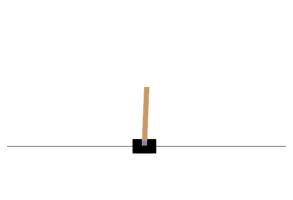

In [14]:
img = plot_environment(env)
plt.show()

### Пример класса для работы с Cartpole

In [22]:
class CartPolePlayer:
    
    def record_scenario(self, env, policy, num_frames=100) -> dict:
        frames = []
        obs_mat = np.empty((num_frames, 4))
        actions = np.empty((num_frames,))
        rewards = np.empty((num_frames,))
        dones = np.empty((num_frames,), dtype=int)
        first_done_info = ''
        obs = env.reset()  # initial observation
        obs = obs[0]
    
        for i in range(num_frames):
            action = policy(obs)
            obs, reward, terminated, truncated, info = env.step(action)
            img = env.render()
            frames.append(img)
            obs_mat[i,:] = obs
            actions[i] = action
            rewards[i] = reward
            dones[i] = int(terminated)
        
            if terminated and first_done_info == '':
                first_done_info = info

        record = {'frames': frames, 'obs': obs_mat, 'actions': actions, 'rewards': 
              rewards, 'dones': dones, 'first_done_info':first_done_info}
        
        return record

    
    def update_scene(self, num, frames, patch, time_text, obs_mat, actions, cum_rewards, dones):
        patch.set_data(frames[num])
        text = f"frame: {num}"
        text += ", Obs: ({:.3f}, {:.3f}, {:.3f}, {:.3f})\n".format(*obs_mat[num,:])
        text += f"Action: {actions[num]}"
        text += f", Cumulative Reward: {cum_rewards[num]}"
        text += f", Done: {dones[num]}"
        time_text.set_text(text)
        
        return patch, time_text
    
    
    def plot_animation(self, record, repeat=False, interval=40):
        '''record should contain
        frames: list of N frames
        obs: (N, 4) array of observations
        actions: (N, ) array of actions {0, 1}
        rewards: (N, ) array of rewards at each step {0, 1}
        dones: (N, 1) array of dones {0, 1}
        '''
        cum_rewards = np.cumsum(record['rewards'])
        frames = record['frames']
        fig = plt.figure()
        patch = plt.imshow(record['frames'][0])
        ax = plt.gca()
        time_text = ax.text(0., 0.95,'',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes)
        plt.axis('off')
        anim = animation.FuncAnimation(
            fig, self.update_scene, fargs=(frames, patch, time_text, record['obs'], record['actions'], cum_rewards, record['dones']),
            frames=len(frames), repeat=repeat, interval=interval)
        plt.close()
        
        return anim   
    
    
    def test_policy(self, policy_func, n_scenario = 1000, max_actions = 500, verbose=False):
        final_rewards = []

        for episode in range(n_scenario):
            if verbose and episode % 50 == 0:
                print(episode)

            episode_rewards = 0
            obs = env.reset()  # reset to a random position
            obs = obs[0] # for reasons unexplained reset and step return differently formatted observations :(
            for step in range(max_actions):
                action = policy_func(obs)
                obs, reward, terminated, truncated, info = env.step(action)
                episode_rewards += reward
                if terminated:
                    break
            
            final_rewards.append(episode_rewards)
    
        return final_rewards

    
    def plot_policy(self, final_rewards, policy_name:str=''):
        fig = plt.plot(range(len(final_rewards)), final_rewards)
        plt.grid()
        plt.title(policy_name + " Mean Reward {:.2f}, Std Reward {:.2f}".format(np.mean(final_rewards), np.std(final_rewards)))
        plt.ylabel('Cum Reward')
        plt.xlabel('Iteration')
        plt.ylim(0, max(final_rewards) * 1.1)
        
        return fig
    
    
    def save_gif(self, recorded_episode):
        recorded_episode['frames'][1].shape
        write_gif([np.transpose(f, axes=[2,0, 1]) for f in recorded_episode['frames']], 'recorded_episode.gif', fps=30)

In [23]:
player = CartPolePlayer()

### Стратегия случайных действий

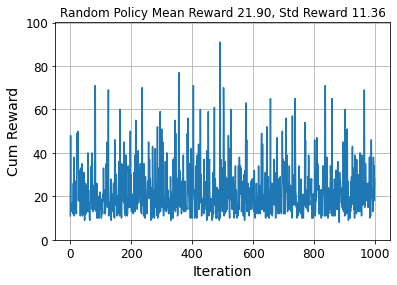

In [24]:
random.seed(0)

def rand_policy(obs):
    return random.randint(0, 1)

rand_rewards = player.test_policy(rand_policy)
pt = player.plot_policy(rand_rewards, "Random Policy")

### Наивная стратегия (управление по отклонению маятника)

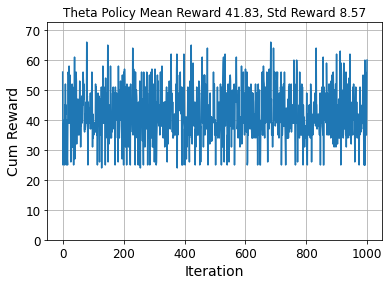

In [25]:
def theta_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

theta_rewards = player.test_policy(theta_policy)
pt = player.plot_policy(theta_rewards, "Theta Policy")

### Наивная стратегия (управление по угловой скорости)

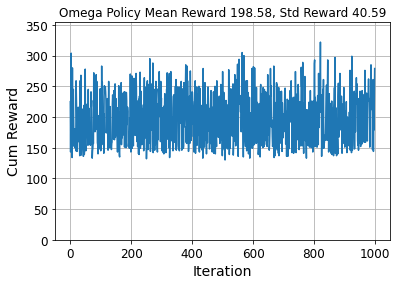

In [26]:
def omega_policy(obs):
    w = obs[3]
    return 1 if w > 0 else 0

omega_rewards = player.test_policy(omega_policy)
pt = player.plot_policy(omega_rewards, "Omega Policy")

### Комбинация двух наивных стратегий, внезапно приводящая к успеху

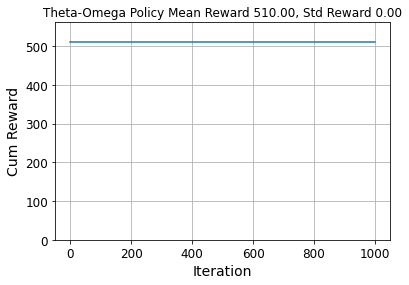

In [27]:
def theta_omega_policy(obs):
    theta, w = obs[2:4]
    if abs(theta) < 0.03:
        return 0 if w < 0 else 1
    else:
        return 0 if theta < 0 else 1

# the cart-pole experiment will end if it lasts more than 500 steps, with info="'TimeLimit.truncated': True"
theta_omega_rewards = player.test_policy(theta_omega_policy, max_actions=510) 
player.plot_policy(theta_omega_rewards, "Theta-Omega Policy")

### Запись эпизода

In [21]:
theta_record = player.record_scenario(env, theta_omega_policy, 100)

### Анимация

In [ ]:
player.plot_animation(theta_record)

### Сохранение gif

In [ ]:
player.save_gif(theta_record)

# строка для маркдаун - <img src="recorded_episode.gif" width="750" align="center">

### Пример Q-learning

пример адаптирован  [со статьи Aleksandar Haber](https://aleksandarhaber.com/q-learning-in-python-with-tests-in-cart-pole-openai-gym-environment-reinforcement-learning-tutorial/)

#### класс для работы с q-learning

In [ ]:
class Q_Learning:
    ###########################################################################
    #  __init__ function
    ###########################################################################
    # INPUTS: 
    # env - Cart Pole environment
    # alpha - learning rate 
    # gamma - discount rate
    # epsilon - parameter for epsilon-greedy approach
    # episodes_count - total number of simulation episodes
     
    # bin_counts - this is a 4 dimensional list that defines the number of grid points 
    # for state discretization
    # that is, this list contains number of bins for every state entry, 
    # we have 4 entries, that is,
    # discretization for cart position, cart velocity, pole angle, and pole angular velocity
     
    # lower_bounds - lower bounds (limits) for discretization, list with 4 entries:
    # lower bounds on cart position, cart velocity, pole angle, and pole angular velocity
 
    # upper_bounds - upper bounds (limits) for discretization, list with 4 entries:
    # upper bounds on cart position, cart velocity, pole angle, and pole angular velocity
     
    def __init__(self, env, alpha, gamma, epsilon, episodes_count, bin_counts, lower_bounds, upper_bounds):
        import numpy as np
         
        self.env = env
        self.alpha = alpha
        self.gamma = gamma 
        self.epsilon = epsilon 
        self.actions_count = env.action_space.n 
        self.episodes_count = episodes_count
        self.bin_counts = bin_counts
        self.lower_bounds = lower_bounds
        self.upper_bounds = upper_bounds
         
        # this list stores sum of rewards in every learning episode
        self.episodes_cum_rewards = []
         
        # this matrix is the action value function matrix 
        binSz = (bin_counts[0], bin_counts[1], bin_counts[2], bin_counts[3], self.actions_count)
        self.Qmatrix = np.random.uniform(low=0, high=1, size=binSz)
        

    ###########################################################################
    # function "calc_state_idx"
    # for the given 4-dimensional state, and discretization grid defined by 
    # numberOfBins, lowerBounds, and upperBounds, this function will return 
    # the index tuple (4-dimensional) that is used to index entries of the 
    # of the QvalueMatrix 
 
 
    # INPUTS:
    # state - state list/array, 4 entries: 
    # cart position, cart velocity, pole angle, and pole angular velocity
 
    # OUTPUT: 4-dimensional tuple defining the indices of the QvalueMatrix 
    # that correspond to "state" input
 
    ###############################################################################
    def calc_state_idx(self, state):
        position        = state[0]
        velocity        = state[1]
        angle           = state[2]
        angularVelocity = state[3]
         
        cart_pos_bin     = np.linspace(self.lower_bounds[0], self.upper_bounds[0], self.bin_counts[0])
        cart_vel_bin     = np.linspace(self.lower_bounds[1], self.upper_bounds[1], self.bin_counts[1])
        pole_angle_bin   = np.linspace(self.lower_bounds[2], self.upper_bounds[2], self.bin_counts[2])
        pole_ang_vel_bin = np.linspace(self.lower_bounds[3], self.upper_bounds[3], self.bin_counts[3])
         
        pos_idx     = np.maximum(np.digitize(state[0], cart_pos_bin) - 1, 0)
        vel_idx     = np.maximum(np.digitize(state[1], cart_vel_bin) - 1, 0)
        angle_idx   = np.maximum(np.digitize(state[2], pole_angle_bin) - 1, 0)
        ang_vel_idx = np.maximum(np.digitize(state[3], pole_ang_vel_bin) - 1, 0)
         
        return tuple([pos_idx, vel_idx, angle_idx, ang_vel_idx])   

        
    ###########################################################################
    # function for selecting an action: epsilon-greedy approach
    ###########################################################################
    # this function selects an action on the basis of the current state 
    # INPUTS: 
    # state - state for which to compute the action
    # index - index of the current episode
    def select_action(self, state, index):
         
        # first 500 episodes we select completely random actions to have enough exploration
        if index < 500:
            return np.random.choice(self.actions_count)   
             
        # Returns a random real number in the half-open interval [0.0, 1.0)
        # this number is used for the epsilon greedy approach
        rand_number = np.random.random()
         
        # after 7000 episodes, we slowly start to decrease the epsilon parameter
        if index > 7000:
            self.epsilon = 0.999 * self.epsilon
         
        # if this condition is satisfied, we are exploring, that is, we select random actions
        if rand_number < self.epsilon:
            # returns a random action selected from: 0,1,...,actionNumber-1
            return np.random.choice(self.actions_count)            
         
        # otherwise, we are selecting greedy actions
        else:
            # we return the index where Qmatrix[state,:] has the max value
            # that is, since the index denotes an action, we select greedy actions
            return np.random.choice(np.where(self.Qmatrix[self.calc_state_idx(state)] == np.max(self.Qmatrix[self.calc_state_idx(state)]))[0])
            # here we need to return the minimum index since it can happen
            # that there are several identical maximal entries, for example 
            # import numpy as np
            # a=[0,1,1,0]
            # np.where(a==np.max(a))
            # this will return [1,2], but we only need a single index
            # that is why we need to have np.random.choice(np.where(a==np.max(a))[0])
            # note that zero has to be added here since np.where() returns a tuple
     
     
    ###########################################################################
    #  function for simulating learning episodes
    ###########################################################################      
    def simulate_episodes(self):
        # here we loop through the episodes
        for episode_idx in range(self.episodes_count):
             
            # list that stores rewards per episode - this is necessary for keeping track of convergence 
            episode_rewards = []
             
            # reset the environment at the beginning of every episode
            current_state = self.env.reset()
            current_state = current_state[0]
            current_state = list(current_state) # s
           
            print("Simulating episode {}".format(episode_idx))             
             
            # here we step from one state to another
            # this will loop until a terminal state is reached
            terminal_state = False
            while not terminal_state:
                # return a discretized index of the state
                 
                current_state_idx = self.calc_state_idx(current_state)
                 
                # select an action on the basis of the current state, denoted by stateS
                current_action = self.select_action(current_state, episode_idx) #  a
                                  
                # here we step and return the state, reward, and boolean denoting if the state is a terminal state
                # prime means that it is the next state
                (next_state, reward, terminal_state, _, _) = self.env.step(current_action)          
                 
                episode_rewards.append(reward) # r
                 
                next_state = list(next_state) # s'
                 
                next_state_idx = self.calc_state_idx(next_state)
                 
                # return the max value, we do not need actionAprime...
                Qmax_next = np.max(self.Qmatrix[next_state_idx])
                                              
                if not terminal_state:
                    # state+(action,) - we use this notation to append the tuples
                    # for example, for current_state = (0, 0, 0, 1) and current_action = (1, 0)
                    # we have current_state + (current_action,) = (0, 0, 0, 1, 0)
                    q_update = reward + self.gamma * Qmax_next - self.Qmatrix[current_state_idx + (current_action,)]
                    self.Qmatrix[current_state_idx + (current_action,)] = self.Qmatrix[current_state_idx + (current_action,)] + self.alpha * q_update
                else:
                    # in the terminal state, we have Qmatrix[next_state, next_action] = 0 
                    q_update = reward - self.Qmatrix[current_state_idx + (current_action,)]
                    self.Qmatrix[current_state_idx + (current_action,)] = self.Qmatrix[current_state_idx + (current_action,)] + self.alpha * q_update
                 
                # set the current state to the next state                    
                current_state = next_state
         
            print("Sum of rewards {}".format(np.sum(episode_rewards)))        
            self.episodes_cum_rewards.append(np.sum(episode_rewards))
     
     
    ###########################################################################
    # function for simulating the final learned optimal policy
    ###########################################################################
    # OUTPUT: 
    # obtained_rewards - a list of obtained rewards during time steps of a single episode    
    # cartpole_env - created Cart Pole environment
     
    # simulate the final learned optimal policy
    def simulate_learned_strategy(self):
        cartpole_env = gym.make('CartPole-v1', render_mode = 'human')
        state = cartpole_env.reset()
        state = state[0]
        cartpole_env.render()
        time_steps = 1000
        
        # obtained rewards at every time step
        obtained_rewards = []
         
        for time_step_idx in range(time_steps):
            print(time_step_idx)
            
            # select greedy actions
            action = np.random.choice(np.where(self.Qmatrix[self.calc_state_idx(state)] == np.max(self.Qmatrix[self.calc_state_idx(state)]))[0])
            state, reward, terminated, truncated, info = cartpole_env.step(action)
            obtained_rewards.append(reward)
            
            time.sleep(0.05)
            if (terminated):
                time.sleep(1)
                break

        return obtained_rewards, cartpole_env
    
    
    ###########################################################################
    #   function for simulating random actions many times
    #   this is used to evaluate the optimal policy and to compare it with a random policy
    ###########################################################################
    #  OUTPUT:
    # cartpole_env - created Cart Pole environment
    # episodes_cum_rewards - every entry of this list is a sum of rewards obtained by simulating the corresponding episode
    def simulate_random_strategy(self):
        cartpole_env = gym.make('CartPole-v1', render_mode = 'human')
        state = cartpole_env.reset()
        state = state[0]
        cartpole_env.render()
        # number of simulation episodes
        episodes_count = 100
        # time steps in every episode
        time_steps = 1000
        # sum of rewards in each episode
        episodes_cum_rewards = []         
         
        for episode_idx in range(episodes_count):
            episode_rewards = []
            initial_state = cartpole_env.reset()
            print(episodeIndex)

            for timeIndex in range(time_steps):
                random_action=cartpole_env.action_space.sample()
                observation, reward, terminated, truncated, info = cartpole_env.step(random_action)
                episode_rewards.append(reward)

                if (terminated):
                    break

            episodes_cum_rewards.append(np.sum(episode_rewards))
            
        return episodes_cum_rewards, cartpole_env 

#### пример работы с q-learning классом

In [ ]:
env = gym.make('CartPole-v1', render_mode = 'human')
state = env.reset()
 
# here define the parameters for state discretization
upper_bounds = env.observation_space.high
lower_bounds = env.observation_space.low
cart_velocity_min = -3
cart_velocity_max = 3
pole_angle_velocity_min = -10
pole_angle_velocity_max = 10
upper_bounds[1] = cart_velocity_max
upper_bounds[3] = pole_angle_velocity_max
lower_bounds[1] = cart_velocity_min
lower_bounds[3] = pole_angle_velocity_min
 
posiiton_bins_count = 30
velocity_bins_count = 30
angle_bins_count = 30
ang_velocity_bins_count = 30
bins_counts = [posiiton_bins_count, velocity_bins_count, angle_bins_count, ang_velocity_bins_count]
 
# define the parameters
alpha = 0.1
gamma = 1
epsilon = 0.2
episodes_count = 15000
 
# create an object
Q1 = Q_Learning(env, alpha, gamma, epsilon, episodes_count, bins_counts, lower_bounds, upper_bounds)
# run the Q-Learning algorithm
Q1.simulate_episodes()
# simulate the learned strategy
(optimal_rewards, env1) = Q1.simulate_learned_strategy()
 
plt.figure(figsize=(12, 5))

# plot the figure and adjust the plot parameters
plt.plot(Q1.episodes_cum_rewards, color='blue', linewidth=1)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.yscale('log')
plt.show()
plt.savefig('convergence.png')
 
# close the environment
env1.close()
# get the sum of rewards
np.sum(optimal_rewards)
 
# now simulate a random strategy
(rand_strategy_rewards, env2) = Q1.simulate_random_strategy()
plt.hist(rand_strategy_rewards)
plt.xlabel('Sum of rewards')
plt.ylabel('Percentage')
plt.savefig('histogram.png')
plt.show()
 
# run this several times and compare with a random learning strategy
(optimal_rewards, env1) = Q1.simulate_learned_strategy()